# t-SNE Implementation (Basic Version)

This notebook implements the t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm from scratch using only Python and NumPy, adhering to the assignment requirements.

### Overview of Functions:
1. **`calculate_high_dim_prob(X, perplexity)`**: Converts Euclidean distances in high-dimensional space into conditional probabilities using Gaussian kernels. It performs a binary search for $\sigma_i$ to match the user-specified perplexity.
2. **`calculate_low_dim_prob(Y)`**: Computes pairwise affinities in the low-dimensional map using a Student t-distribution with one degree of freedom. This heavy-tailed distribution helps alleviate the "crowding problem".
3. **`tsne(X, ...)`**: The main driver function that minimizes the Kullback-Leibler (KL) divergence between high-dimensional probabilities ($P$) and low-dimensional probabilities ($Q$) using Gradient Descent with momentum and adaptive learning rates.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

## 1. High-Dimensional Affinities

The function `calculate_high_dim_prob` computes the similarity matrix $P$. For every pair of points, we compute the conditional probability $p_{j|i}$ that $x_i$ would choose $x_j$ as its neighbor using a Gaussian kernel centered at $x_i$. 

We use a binary search to find the optimal bandwidth $\sigma_i$ (or precision $\beta_i = 1/2\sigma_i^2$) such that the entropy of the conditional distribution equals $\log(\text{perplexity})$.

In [3]:
def calculate_high_dim_prob(X, perplexity=30.0):
    n = X.shape[0]
    # Compute pairwise squared Euclidean distances
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    P = np.zeros((n, n))
    beta = np.ones((n, 1)) # beta = 1 / (2 * sigma^2)
    logU = np.log(perplexity)
    
    # Binary search for each point's optimal sigma
    for i in range(n):
        beta_min = 0.0
        beta_max = np.inf
        
        # Exclude self-distance
        Di = np.delete(D[i, :], i)
        
        for _ in range(50):
            Hbeta = np.exp(-Di * beta[i])
            sum_Hbeta = np.sum(Hbeta) + 1e-12
            
            # Entropy calculation
            H = np.log(sum_Hbeta) + beta[i] * np.sum(Di * Hbeta) / sum_Hbeta
            diff = H - logU
            
            if np.abs(diff) < 1e-5:
                break
            
            if diff > 0:
                beta_min = beta[i]
                if beta_max == np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + beta_max) / 2
            else:
                beta_max = beta[i]
                beta[i] = (beta[i] + beta_min) / 2
                
        # Compute final row probabilities
        Hbeta = np.exp(-D[i, :] * beta[i])
        Hbeta[i] = 0
        P[i, :] = Hbeta / (np.sum(Hbeta) + 1e-12)
        
    # Symmetrize and normalize
    P = (P + P.T) / (2 * n)
    return np.maximum(P, 1e-12)

## 2. Low-Dimensional Affinities

In the low-dimensional map, we use a **Student t-distribution with one degree of freedom** (Cauchy distribution). This heavy-tailed distribution allows distant points in high-dimensional space to be modeled faithfully in 2D without "crowding" the center of the map.

In [4]:
def calculate_low_dim_prob(Y):
    # Student t-distribution (1 / (1 + dist^2))
    sum_Y = np.sum(np.square(Y), axis=1)
    num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
    np.fill_diagonal(num, 0)
    Q = num / np.sum(num)
    return np.maximum(Q, 1e-12), num

## 3. Optimization (Gradient Descent)

The optimization process minimizes the KL divergence: $C = KL(P||Q) = \sum p_{ij} \log(p_{ij}/q_{ij})$.

**Key features of this implementation:**
- **Early Exaggeration**: We multiply $P$ by 4 for the initial 100 iterations. This forces clusters to separate widely, creating empty space for easier navigation later.
- **Momentum**: Reduces oscillation. Starts at 0.5 and increases to 0.8 after 250 iterations.
- **Adaptive Learning Rates**: We use a simple gain adjustment (similar to delta-bar-delta) to speed up convergence.

In [5]:
def tsne(X, n_components=2, perplexity=30.0, n_iter=1000, learning_rate=200.0):
    n, d = X.shape
    
    print("Computing pairwise affinities...")
    P = calculate_high_dim_prob(X, perplexity)
    
    # Early exaggeration
    P = P * 4
    
    # Initialize Y
    Y = np.random.randn(n, n_components) * 1e-4
    
    dY = np.zeros_like(Y)
    iY = np.zeros_like(Y)
    gains = np.ones_like(Y)
    
    print(f"Starting gradient descent ({n_iter} iterations)...")
    for i in range(n_iter):
        Q, num = calculate_low_dim_prob(Y)
        
        # Calculate gradient: 4 * sum((P - Q) * num * (Yi - Yj))
        PQ = P - Q
        # Vectorized gradient calculation
        # The equation for gradient is: dC/dy_i = 4 * sum_j (p_ij - q_ij)(1 + ||y_i - y_j||^2)^-1 (y_i - y_j)
        # We can use NumPy broadcasting -> (P - Q) * num is a matrix scaling factor for pairwise vectors
        for j in range(n):
            dY[j, :] = 4 * np.sum((PQ[j, :] * num[j, :])[:, np.newaxis] * (Y[j, :] - Y), axis=0)
            
        # Momentum adjustment
        if i < 250:
            momentum = 0.5
        else:
            momentum = 0.8
            
        # Stop early exaggeration
        if i == 100:
            P = P / 4
            
        # Adaptive learning rate (gains)
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + \
                (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < 0.01] = 0.01
        
        # Update using momentum and gradient
        iY = momentum * iY - learning_rate * (gains * dY)
        Y = Y + iY
        Y = Y - np.mean(Y, axis=0) # Re-center
        
        if (i + 1) % 100 == 0:
            error = np.sum(P * np.log(P / Q))
            print(f"Iteration {i+1}, Error: {error:.4f}")
            
    return Y

## 4. Execution and Visualization

We use the **digits** dataset from Scikit-Learn (similar to MNIST). We select a subset of 500 n_samples for a quick demonstration.

Running t-SNE on 500 MNIST digits...
Computing pairwise affinities...
Starting gradient descent (1000 iterations)...
Iteration 100, Error: 12.3855
Iteration 200, Error: 0.4921
Iteration 300, Error: 0.4241
Iteration 400, Error: 0.4045
Iteration 500, Error: 0.3983
Iteration 600, Error: 0.3953
Iteration 700, Error: 0.3935
Iteration 800, Error: 0.3924
Iteration 900, Error: 0.3916
Iteration 1000, Error: 0.3911


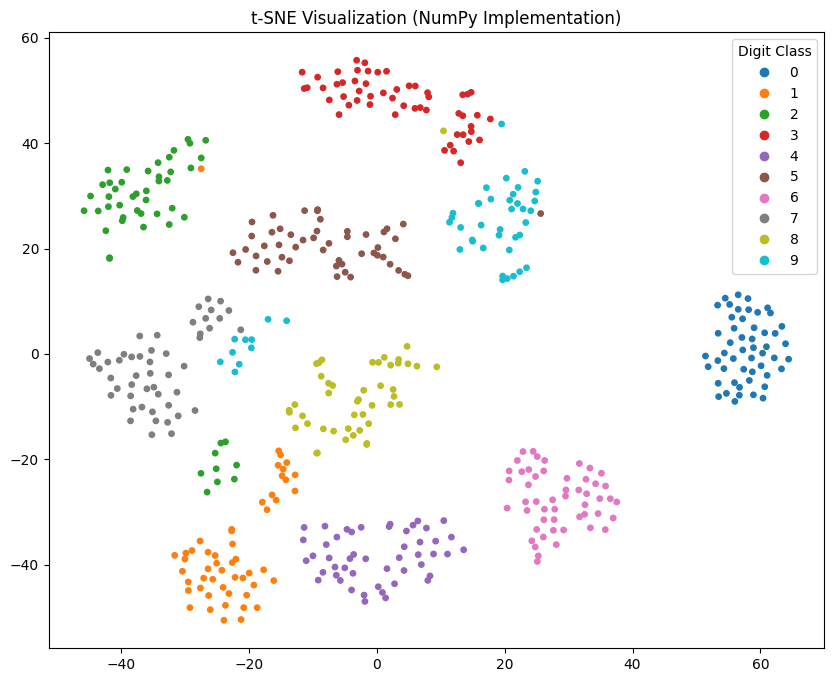

In [6]:
# Load data
digits = load_digits()
X = digits.data
y = digits.target

# Use subset for demonstration speed
n_samples = 500
print(f"Running t-SNE on {n_samples} MNIST digits...")

X_subset = X[:n_samples] / 16.0 # Normalize 0-1
y_subset = y[:n_samples]

Y = tsne(X_subset)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=y_subset, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="Digit Class")
plt.title("t-SNE Visualization (NumPy Implementation)")
plt.show()